In [ ]:
# Importing necessary packages
import os, re, json, math, nltk, pickle
import pandas as pd
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Setting paths
path_to_json = 'pdf_json/'
drive_directory = 'drive/MyDrive/NLP/'

Mounted at /content/drive


In [ ]:
#Building the vocab
from collections import Counter
vocab = Counter()
token_files = [batch for batch in os.listdir(drive_directory) if batch.startswith('w2v_batch_')]
for i in token_files:
  with open(drive_directory+i, 'rb') as f:
    vocab.update(pickle.load(f))
print("The Vocabulary count of the corpus is:", len(vocab.keys()))

The Vocabulary count of the corpus is: 60228


In [ ]:
#Selecting vocab with word frequency >139
vocab_selected = []
vocab_keys = list(vocab.keys())
for i in range(len(vocab_keys)):
  freq = vocab[vocab_keys[i]]
  if freq>139:
    vocab_selected.append(vocab_keys[i])
len(vocab_selected)

14010

In [ ]:
for t in token_files:
  with open(drive_directory+t, 'rb') as f:
    tokens = pickle.load(f)

#### Building Co-occurrence matrix

In [ ]:
from tqdm import tqdm
co_matrix = np.zeros((len(vocab_selected), len(vocab_selected)))
for i, word in enumerate(tqdm(tokens)):
  if word in vocab_selected:
    for j in range(i+1,min(i+10,len(tokens))):
      reward = 10
      if tokens[j] in vocab_selected:
        co_matrix[vocab_selected.index(word)][vocab_selected.index(tokens[j])] += reward
        co_matrix[vocab_selected.index(tokens[j])][vocab_selected.index(word)] += reward
      reward-=1

100%|██████████| 14024026/14024026 [3:02:50<00:00, 1278.39it/s]


#### Converting the Co-occurrence matrix to a sparse matrix

In [ ]:
# create a sparse matrix in CSR format

from scipy.sparse import csr_matrix
sparse_matrix = csr_matrix(np.array(co_matrix))

In [ ]:
# saving the sparse matrix

import scipy.sparse as sp
sp.save_npz(drive_directory+"sparse_matrix.npz", sparse_matrix)

In [ ]:
import scipy.sparse as sp
sparse_matrix = sp.load_npz(drive_directory+"sparse_matrix.npz")

#### Building pairwise distance matrix (Euclidean Distance)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
distance_matrix = pairwise_distances(sparse_matrix, metric='euclidean')
print(distance_matrix)

[[0.00000000e+00 6.29315601e+06 6.59375088e+06 ... 6.59794867e+06
  6.59520051e+06 6.59797978e+06]
 [6.29315601e+06 0.00000000e+00 3.04086551e+05 ... 3.08342578e+05
  3.05562985e+05 3.08373056e+05]
 [6.59375088e+06 3.04086551e+05 0.00000000e+00 ... 4.77940373e+03
  2.87351701e+03 4.80155183e+03]
 ...
 [6.59794867e+06 3.08342578e+05 4.77940373e+03 ... 0.00000000e+00
  3.12397183e+03 5.09901951e+01]
 [6.59520051e+06 3.05562985e+05 2.87351701e+03 ... 3.12397183e+03
  0.00000000e+00 3.15046028e+03]
 [6.59797978e+06 3.08373056e+05 4.80155183e+03 ... 5.09901951e+01
  3.15046028e+03 0.00000000e+00]]


In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Perform SVD
svd = TruncatedSVD(n_components=2)
# readucing the dimension of the matrix to visualize the word vectors in 2D
word_vectors = svd.fit_transform(sparse_matrix)

In [ ]:
# Selecting 4 nouns to find the similar words for

nouns = ['problem', 'world', 'simulation', 'economy']
word_indices =[]
for noun in nouns:
  word_indices.append(vocab_selected.index(noun))

In [ ]:
# Defining a function to find similar words

def similar_words(word_index):
  similar_words=[]
  similar_words_index = np.argsort(distance_matrix[word_index])
  # The smaller the distance, greater the similarity
  for i in range(len(similar_words_index)):
    similar_words.append(vocab_selected[similar_words_index[i]])
  nouns = [word for (word, pos) in nltk.pos_tag(similar_words) if is_noun(pos)]
  return nouns[1:11]

#### Finding similar words

In [ ]:
# saving the similar words and the nouns as a dictionary

nltk.download('averaged_perceptron_tagger')
is_noun = lambda pos: pos[:2] == 'NN'
similar_words_dict = {}
for word_index in word_indices:
  sw = similar_words(word_index)
  for i,w in enumerate(sw):
    label = vocab_selected[vocab_selected.index(w)]
    value = [word_vectors[vocab_selected.index(w)][0], word_vectors[vocab_selected.index(w)][1],
             vocab_selected[word_index]]
    similar_words_dict.update({label:value})


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# converting the dictionary into dataframe

df = pd.DataFrame(similar_words_dict).T
df.columns = ['x','y','word']


#### Similar words

In [ ]:
# printing the similar words for each noun

print("Selected Noun: Problem")
print("Similar Words:",list(df.index[df.word == 'problem']))
print("Selected Noun: World")
print("Similar Words:",list(df.index[df.word == 'world']))
print("Selected Noun: Simulation")
print("Similar Words:",list(df.index[df.word == 'simulation']))
print("Selected Noun: Economy")
print("Similar Words:",list(df.index[df.word == 'economy']))

Selected Noun: Problem
Similar Words: ['strategy', 'way', 'condition', 'source', 'field', 'probability', 'application', 'environment', 'measure', 'procedure']
Selected Noun: World
Similar Words: ['epidemic', 'state', 'outbreak', 'change', 'distribution', 'site', 'target', 'form', 'network', 'size']
Selected Noun: Simulation
Similar Words: ['input', 'parameter', 'prediction', 'location', 'curve', 'base', 'random', 'towards', 'framework', 'feature']
Selected Noun: Economy
Similar Words: ['direction', 'sector', 'force', 'price', 'map', 'rest', 'mobility', 'movement', 'uncertainty', 'interface']


In [ ]:
columns = ["word1","word2","word3","word4","word5"]
data = {nouns[0]:list(df.index[df.word == 'problem'])[:5],
          nouns[1]:list(df.index[df.word == 'world'])[:5],
          nouns[2]:list(df.index[df.word == 'simulation'])[:5],
          nouns[3]:list(df.index[df.word == 'economy'])[:5]}
df1 = pd.DataFrame(data, columns).T
df1

,word1,word2,word3,word4,word5
problem,strategy,way,condition,source,field
world,epidemic,state,outbreak,change,distribution
simulation,input,parameter,prediction,location,curve
economy,direction,sector,force,price,map


#### Plotting the similar words

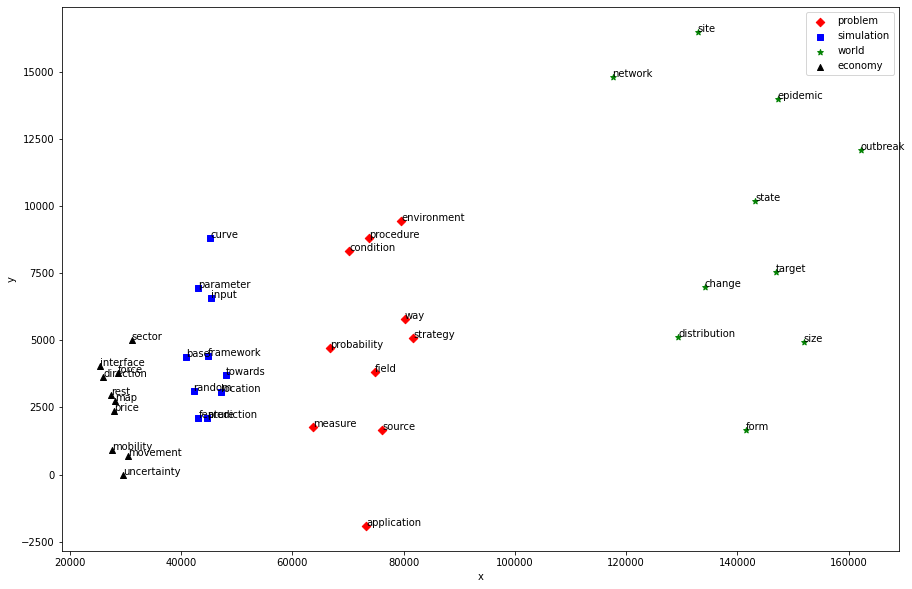

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
labels=list(df.index)
for i, label in enumerate(labels):
    plt.annotate(label, (df.x[i], df.y[i]))
plt.scatter(df['x'][(df.word == 'problem')],
            df['y'][(df.word == 'problem')],
           marker='D',
           color='red',
           label='problem')
plt.scatter(df['x'][df.word == 'simulation'],
            df['y'][df.word == 'simulation'],
           marker='s',
           color='blue',
           label='simulation')
plt.scatter(df['x'][df.word == 'world'],
            df['y'][df.word == 'world'],
           marker='*',
           color='green',
           label='world')
plt.scatter(df['x'][df.word == 'economy'],
            df['y'][df.word == 'economy'],
           marker='^',
           color='black',
           label='economy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

We can see that the similar words for each noun have been grouped into different clusters.